In [4]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import robust_loss_pytorch.general

# Construct some regression data with some extreme outliers.
np.random.seed(1)
n = 50
scale_true = 0.7
shift_true = 0.15
x = np.random.uniform(size=n)
y = scale_true * x + shift_true
y += np.random.normal(scale=0.025, size=n)
flip_mask = np.random.uniform(size=n) > 0.9
y = np.where(flip_mask, 0.05 + 0.4 * (1. - np.sign(y - 0.5)), y)

x = torch.Tensor(x)
y = torch.Tensor(y)

class RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(1, 1)
    def forward(self, x): 
        return self.linear(x[:,None])[:,0]

def plot_regression(regression):
    # A helper function for plotting a regression module.
    x_plot = np.linspace(0, 1, 100)
    y_plot = regression(torch.Tensor(x_plot)).detach().numpy()
    y_plot_true = x_plot * scale_true + shift_true

    plt.figure(0, figsize=(4,4))
    plt.scatter(x, y)
    plt.plot(x_plot, y_plot_true, color='k')
    plt.plot(x_plot, y_plot, color='r')

0   : loss=6.892803
100 : loss=1.706846
200 : loss=1.674322
300 : loss=1.673696
400 : loss=1.673694
500 : loss=1.673694
600 : loss=1.673694
700 : loss=1.673694
800 : loss=1.673694
900 : loss=1.673694
1000: loss=1.673694
1100: loss=1.673694
1200: loss=1.673694
1300: loss=1.673694
1400: loss=1.673694
1500: loss=1.673694
1600: loss=1.673694
1700: loss=1.673694
1800: loss=1.673694
1900: loss=1.673694


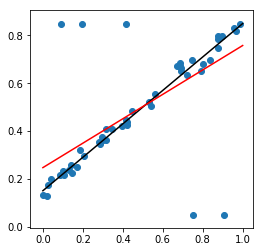

In [11]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 

# It doesn't fit well.
plot_regression(regression)

0   : loss=1.497499  alpha=1.004995  scale=0.993690
100 : loss=0.365647  alpha=1.460623  scale=0.433759
200 : loss=-0.307419  alpha=1.678272  scale=0.181545
300 : loss=-0.440313  alpha=1.445860  scale=0.125634
400 : loss=-0.747422  alpha=0.771877  scale=0.074583
500 : loss=-1.213966  alpha=0.286796  scale=0.031820
600 : loss=-1.439339  alpha=0.127493  scale=0.017698
700 : loss=-1.485178  alpha=0.074832  scale=0.014162
800 : loss=-1.498284  alpha=0.052338  scale=0.013124
900 : loss=-1.503734  alpha=0.040308  scale=0.012733
1000: loss=-1.507125  alpha=0.032830  scale=0.012530
1100: loss=-1.509135  alpha=0.027691  scale=0.012406
1200: loss=-1.510411  alpha=0.023921  scale=0.012322
1300: loss=-1.511533  alpha=0.021025  scale=0.012260
1400: loss=-1.512304  alpha=0.018723  scale=0.012211
1500: loss=-1.512898  alpha=0.016844  scale=0.012176
1600: loss=-1.513401  alpha=0.015280  scale=0.012141
1700: loss=-1.513436  alpha=0.013955  scale=0.012122
1800: loss=-1.514139  alpha=0.012819  scale=0.01

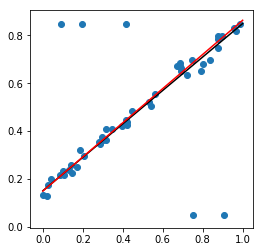

In [15]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu')
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 

# It fits!
plot_regression(regression)